# Part 3: Polymarket Sentiment Signals

**Parts 1 & 2** established that *timing* (weekday, month) is irrelevant and *valuation signals* (MVRV, NVT) can modestly improve DCA efficiency. This notebook explores whether **prediction-market sentiment** from Polymarket adds predictive value for BTC price direction.

**Data:** 6 Polymarket parquet files covering finance/politics/crypto markets (2022–2026), plus Coin Metrics BTC on-chain data.

**Approach:**
1. Load and clean Polymarket data; fix known timestamp corruption (millis stored as micros)
2. Filter to BTC-related markets; construct daily sentiment features from odds, trades, and market activity
3. Merge with BTC price data to define a prediction target (next-day / next-week return direction)
4. EDA of sentiment features; correlation, tree-based importance, mutual information, Lasso, and lag analysis
5. Produce a unified predictor ranking to inform the strategy engine in Part 4

**Key question:** Do crowd predictions on Polymarket contain leading information about BTC price moves beyond what on-chain metrics already capture?

## 1. Setup and Configuration

In [5]:
from __future__ import annotations

from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats

# --- Plot style (consistent with Parts 1 & 2) ---
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# --- Paths ---
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "eda" else NOTEBOOK_DIR
DATA_DIR = PROJECT_ROOT / "data"
POLYMARKET_DIR = DATA_DIR / "Polymarket"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
PLOTS_DIR = PROJECT_ROOT / "eda" / "plots"
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

# --- Parquet file names ---
PARQUET_FILES = {
    "markets": "finance_politics_markets.parquet",
    "tokens": "finance_politics_tokens.parquet",
    "odds_history": "finance_politics_odds_history.parquet",
    "trades": "finance_politics_trades.parquet",
    "event_stats": "finance_politics_event_stats.parquet",
    "summary": "finance_politics_summary.parquet",
}

print(f"Polymarket dir  : {POLYMARKET_DIR}")
print(f"Coin Metrics CSV: {COINMETRICS_PATH}")
print(f"Plots dir       : {PLOTS_DIR}")
print(f"Parquet files   : {list(PARQUET_FILES.keys())}")

Polymarket dir  : c:\Users\tsivakumar\Projects\OMSA\data\Polymarket
Coin Metrics CSV: c:\Users\tsivakumar\Projects\OMSA\data\Coin Metrics\coinmetrics_btc.csv
Plots dir       : c:\Users\tsivakumar\Projects\OMSA\eda\plots
Parquet files   : ['markets', 'tokens', 'odds_history', 'trades', 'event_stats', 'summary']


## 2. Load & Clean Data

Load all Polymarket parquets + Coin Metrics BTC prices. Fix the known timestamp issue (millisecond values stored with microsecond metadata) and filter to BTC-related prediction markets.

In [ ]:
#  2a. Load Coin Metrics BTC prices 
btc_raw = pl.scan_csv(str(COINMETRICS_PATH), infer_schema_length=10_000).collect()
btc = (
    btc_raw
    .with_columns(pl.col("time").str.to_date("%Y-%m-%d").alias("date"))
    .filter(pl.col("PriceUSD").is_not_null())
    .sort("date")
    .select(["date", "PriceUSD"])
)
print(f"BTC prices: {btc.shape[0]} rows, {btc['date'].min()} → {btc['date'].max()}")

#  2b. Load Polymarket markets 
markets = pd.read_parquet(POLYMARKET_DIR / PARQUET_FILES["markets"])
print(f"All markets: {markets.shape[0]}")

# Filter to BTC-related markets
btc_mask = markets["question"].str.contains("bitcoin|btc|Bitcoin|BTC", case=False, na=False)
btc_markets = markets[btc_mask].copy()
btc_market_ids = set(btc_markets["market_id"])
print(f"BTC markets: {len(btc_markets)}")

#  2c. Fix timestamps 
def fix_ts_column(series: pd.Series) -> pd.Series:
    """Fix mixed Polymarket timestamp encodings safely.

    Some files are already correct datetimes, while others are milliseconds
    stored with microsecond metadata (showing as dates around 1970).
    This function tests both interpretations and keeps the more plausible one.
    """
    if series.empty:
        return series

    if pd.api.types.is_datetime64_any_dtype(series):
        s = pd.to_datetime(series, errors="coerce", utc=True)
    else:
        s = pd.to_datetime(series, errors="coerce", utc=True)

    if s.notna().sum() == 0:
        return s

    keep_as_is = s

    raw = pd.Series(s.astype("int64", copy=False), index=s.index)
    corrected = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns, UTC]")
    valid_mask = s.notna()
    corrected.loc[valid_mask] = pd.to_datetime(
        raw.loc[valid_mask] // 1_000,
        unit="s",
        utc=True,
        errors="coerce",
    )

    def plausibility_score(ts: pd.Series) -> float:
        valid = ts.dropna()
        if valid.empty:
            return -1.0
        yrs = valid.dt.year
        # Polymarket dataset here is expected around 2020–2026
        in_range = ((yrs >= 2015) & (yrs <= 2035)).mean()
        return float(in_range)

    return corrected if plausibility_score(corrected) > plausibility_score(keep_as_is) else keep_as_is

for col in ["created_at", "end_date"]:
    if col in btc_markets.columns:
        btc_markets[col] = fix_ts_column(btc_markets[col])

print(f"BTC market date range: {btc_markets['created_at'].min()} → {btc_markets['created_at'].max()}")

#  2d. Load odds history (BTC markets only) 
odds_raw = pd.read_parquet(POLYMARKET_DIR / PARQUET_FILES["odds_history"])
odds = odds_raw[odds_raw["market_id"].isin(btc_market_ids)].copy()
odds["timestamp"] = fix_ts_column(odds["timestamp"])
odds["date"] = odds["timestamp"].dt.date
print(f"BTC odds rows: {len(odds):,}, markets: {odds['market_id'].nunique()}")

#  2e. Load summary (BTC markets only) 
summary = pd.read_parquet(POLYMARKET_DIR / PARQUET_FILES["summary"])
btc_summary = summary[summary["market_id"].isin(btc_market_ids)].copy()
for col in ["first_trade", "last_trade"]:
    if col in btc_summary.columns:
        btc_summary[col] = fix_ts_column(btc_summary[col])
print(f"BTC summary rows: {len(btc_summary)}")

#  2f. Load tokens (BTC markets only) 
tokens = pd.read_parquet(POLYMARKET_DIR / PARQUET_FILES["tokens"])
btc_tokens = tokens[tokens["market_id"].isin(btc_market_ids)].copy()
print(f"BTC tokens: {len(btc_tokens)}")

print("\n✓ All data loaded and timestamps fixed.")

BTC prices: 5659 rows, 2010-07-18 → 2026-01-13
All markets: 78321
BTC markets: 21921
BTC market date range: 2020-10-02 20:00:04+00:00 → 2025-12-10 05:32:19+00:00
BTC odds rows: 202,033, markets: 14667
BTC summary rows: 21921
BTC tokens: 43842

✓ All data loaded and timestamps fixed.


## 3. Construct Daily Sentiment Features

Aggregate Polymarket signals to a **daily time series** aligned with BTC prices. Features capture crowd sentiment, market activity, and conviction from prediction-market data.

**Feature categories:**
- **Odds-based:** mean/median daily "Yes" price across active BTC markets (crowd probability)
- **Activity-based:** number of active markets, new markets created, markets resolved
- **Volume-based:** total/mean volume of active BTC markets
- **Breadth-based:** fraction of markets pricing "Yes" above 50% (bullish breadth)
- **Dispersion:** standard deviation of odds across markets (consensus vs disagreement)

In [ ]:
# 3a. Identify "Yes" tokens per market
# Most BTC markets are binary (Yes/No). Use the "Yes" token price as the
# crowd probability estimate for the event.
yes_tokens = btc_tokens[btc_tokens["outcome"].str.lower() == "yes"][["market_id", "token_id"]]
yes_token_ids = set(yes_tokens["token_id"])
print(f"Yes tokens mapped: {len(yes_tokens)} across {yes_tokens['market_id'].nunique()} markets")

# Keep only "Yes" odds
odds_yes = odds[odds["token_id"].isin(yes_token_ids)].copy()
print(f"Yes-token odds rows: {len(odds_yes):,}")

# 3b. Daily odds aggregation 
# For each day, compute statistics across all BTC yes-token odds snapshots
daily_odds = (
    odds_yes
    .groupby("date")
    .agg(
        odds_mean=("price", "mean"),
        odds_median=("price", "median"),
        odds_std=("price", "std"),
        odds_min=("price", "min"),
        odds_max=("price", "max"),
        odds_count=("price", "count"),        # total snapshots
        n_markets_odds=("market_id", "nunique"),  # markets with odds that day
    )
    .reset_index()
)
daily_odds["date"] = pd.to_datetime(daily_odds["date"])
print(f"Daily odds features: {daily_odds.shape}")

# 3c. Bullish breadth: fraction of markets with last odds > 0.5
# For each day, get last odds per market, then compute fraction > 0.5
last_odds_per_day = (
    odds_yes
    .sort_values("timestamp")
    .groupby(["date", "market_id"])
    .last()
    .reset_index()
)
bullish_breadth = (
    last_odds_per_day
    .groupby("date")
    .apply(lambda g: (g["price"] > 0.5).mean(), include_groups=False)
    .reset_index(name="bullish_breadth")
)
bullish_breadth["date"] = pd.to_datetime(bullish_breadth["date"])

# 3d. Market creation / resolution activity
btc_markets["created_date"] = btc_markets["created_at"].dt.date
markets_created = (
    btc_markets
    .groupby("created_date")
    .size()
    .reset_index(name="markets_created")
    .rename(columns={"created_date": "date"})
)
markets_created["date"] = pd.to_datetime(markets_created["date"])

# Resolution activity (closed markets with end_date)
closed_markets = btc_markets[btc_markets["closed"] == True].copy()
closed_markets["end_date_day"] = closed_markets["end_date"].dt.date
markets_resolved = (
    closed_markets
    .groupby("end_date_day")
    .size()
    .reset_index(name="markets_resolved")
    .rename(columns={"end_date_day": "date"})
)
markets_resolved["date"] = pd.to_datetime(markets_resolved["date"])

# 3e. Volume features from summary
# Aggregate volume of markets that were active on each day
# Use created_at → end_date as the active window
btc_markets_vol = btc_markets[["market_id", "volume", "created_at", "end_date"]].dropna(subset=["created_at"])
# For simplicity, attribute each market's volume to its creation date
vol_by_creation = (
    btc_markets_vol
    .assign(date=btc_markets_vol["created_at"].dt.date)
    .groupby("date")
    .agg(total_volume_created=("volume", "sum"), mean_volume_created=("volume", "mean"))
    .reset_index()
)
vol_by_creation["date"] = pd.to_datetime(vol_by_creation["date"])

print(f"Bullish breadth: {bullish_breadth.shape}")
print(f"Markets created daily: {markets_created.shape}")
print(f"Markets resolved daily: {markets_resolved.shape}")
print(f"Volume by creation: {vol_by_creation.shape}")

Yes tokens mapped: 7958 across 7958 markets
Yes-token odds rows: 72,989
Daily odds features: (1008, 8)
Bullish breadth: (1008, 2)
Markets created daily: (495, 2)
Markets resolved daily: (484, 2)
Volume by creation: (495, 3)


In [ ]:
# 3f. Merge all daily features with BTC prices
btc_pd = btc.to_pandas()
btc_pd["date"] = pd.to_datetime(btc_pd["date"])

# Start with BTC prices, left-join all Polymarket features
df = btc_pd.copy()
for feat_df in [daily_odds, bullish_breadth, markets_created, markets_resolved, vol_by_creation]:
    df = df.merge(feat_df, on="date", how="left")

# Fill NaN for days with no Polymarket activity (weekends, early dates)
fill_cols = [c for c in df.columns if c not in ("date", "PriceUSD")]
df[fill_cols] = df[fill_cols].fillna(0)

# 3g. Define target variable 
# Forward returns for prediction targets
df["fwd_ret_1d"] = df["PriceUSD"].pct_change(1).shift(-1)   # next-day return
df["fwd_ret_7d"] = df["PriceUSD"].pct_change(7).shift(-7)   # next-week return
df["fwd_dir_1d"] = (df["fwd_ret_1d"] > 0).astype(int)       # 1 = up, 0 = down
df["fwd_dir_7d"] = (df["fwd_ret_7d"] > 0).astype(int)

# 3h. Feature engineering: momentum and volatility 
# Rolling statistics on odds-based features
for window in [7, 14, 30]:
    df[f"odds_mean_{window}d_avg"] = df["odds_mean"].rolling(window, min_periods=1).mean()
    df[f"odds_mean_{window}d_std"] = df["odds_mean"].rolling(window, min_periods=1).std()
    df[f"breadth_{window}d_avg"] = df["bullish_breadth"].rolling(window, min_periods=1).mean()
    df[f"n_markets_{window}d_avg"] = df["n_markets_odds"].rolling(window, min_periods=1).mean()
    df[f"vol_created_{window}d_sum"] = df["total_volume_created"].rolling(window, min_periods=1).sum()

# Sentiment momentum: change in odds mean
df["odds_mean_momentum_7d"] = df["odds_mean"] - df["odds_mean_7d_avg"]
df["breadth_momentum_7d"] = df["bullish_breadth"] - df["breadth_7d_avg"]

# Sentiment divergence from price: when crowd is bullish but price is dropping (or vice versa)
df["price_ret_7d"] = df["PriceUSD"].pct_change(7)
df["sentiment_price_divergence"] = df["odds_mean_momentum_7d"] - df["price_ret_7d"].fillna(0)

# Filter to Polymarket era (data available from ~2023 onwards)
df_poly = df[df["date"] >= "2023-01-01"].copy()
print(f"\nMerged dataset: {df_poly.shape}")
print(f"Date range: {df_poly['date'].min().date()} → {df_poly['date'].max().date()}")
print(f"Non-zero odds days: {(df_poly['odds_mean'] > 0).sum()} / {len(df_poly)}")

# List all features
feature_cols = [c for c in df_poly.columns if c not in (
    "date", "PriceUSD", "fwd_ret_1d", "fwd_ret_7d", "fwd_dir_1d", "fwd_dir_7d"
)]
print(f"\nFeature columns ({len(feature_cols)}):")
for c in feature_cols:
    print(f"  {c}")


Merged dataset: (1109, 37)
Date range: 2023-01-01 → 2026-01-13
Non-zero odds days: 1008 / 1109

Feature columns (31):
  odds_mean
  odds_median
  odds_std
  odds_min
  odds_max
  odds_count
  n_markets_odds
  bullish_breadth
  markets_created
  markets_resolved
  total_volume_created
  mean_volume_created
  odds_mean_7d_avg
  odds_mean_7d_std
  breadth_7d_avg
  n_markets_7d_avg
  vol_created_7d_sum
  odds_mean_14d_avg
  odds_mean_14d_std
  breadth_14d_avg
  n_markets_14d_avg
  vol_created_14d_sum
  odds_mean_30d_avg
  odds_mean_30d_std
  breadth_30d_avg
  n_markets_30d_avg
  vol_created_30d_sum
  odds_mean_momentum_7d
  breadth_momentum_7d
  price_ret_7d
  sentiment_price_divergence


## 4. Exploratory Data Analysis of Sentiment Features

Visualize distributions and time-series behavior of the key Polymarket-derived features.

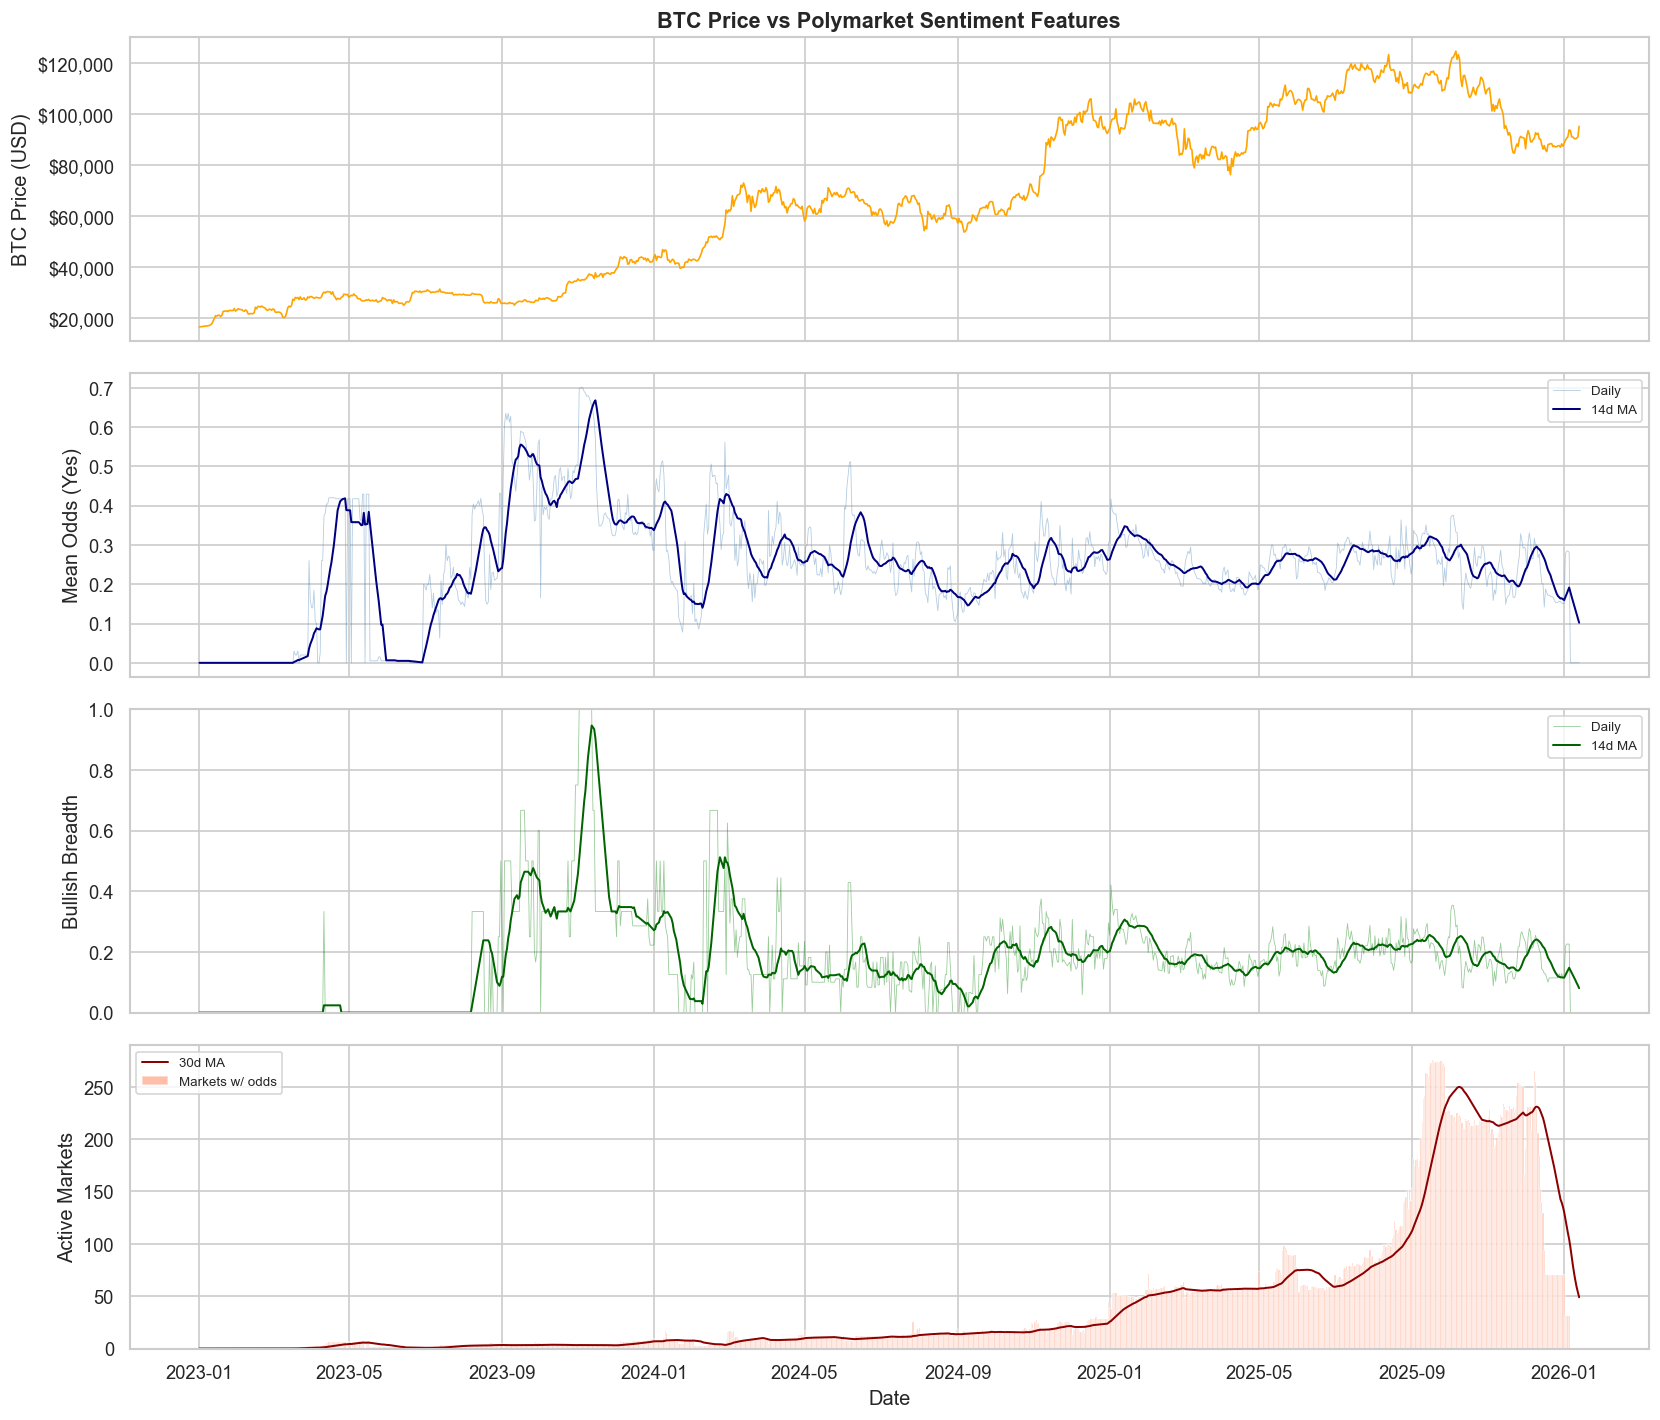

✓ Time series overview saved.


In [ ]:
# 4a. Time series: key features vs BTC price
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# BTC Price
ax = axes[0]
ax.plot(df_poly["date"], df_poly["PriceUSD"], color="orange", linewidth=1)
ax.set_ylabel("BTC Price (USD)")
ax.set_title("BTC Price vs Polymarket Sentiment Features", fontsize=13, fontweight="bold")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

# Odds mean (crowd probability)
ax = axes[1]
ax.plot(df_poly["date"], df_poly["odds_mean"], color="steelblue", alpha=0.4, linewidth=0.5, label="Daily")
ax.plot(df_poly["date"], df_poly["odds_mean_14d_avg"], color="navy", linewidth=1.2, label="14d MA")
ax.set_ylabel("Mean Odds (Yes)")
ax.legend(fontsize=8)

# Bullish breadth
ax = axes[2]
ax.plot(df_poly["date"], df_poly["bullish_breadth"], color="green", alpha=0.4, linewidth=0.5, label="Daily")
ax.plot(df_poly["date"], df_poly["breadth_14d_avg"], color="darkgreen", linewidth=1.2, label="14d MA")
ax.set_ylabel("Bullish Breadth")
ax.set_ylim(0, 1)
ax.legend(fontsize=8)

# Market activity
ax = axes[3]
ax.bar(df_poly["date"], df_poly["n_markets_odds"], color="coral", alpha=0.5, width=1, label="Markets w/ odds")
ax.plot(df_poly["date"], df_poly["n_markets_30d_avg"], color="darkred", linewidth=1.2, label="30d MA")
ax.set_ylabel("Active Markets")
ax.set_xlabel("Date")
ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_timeseries_overview.png", bbox_inches="tight")
plt.show()
print("✓ Time series overview saved.")

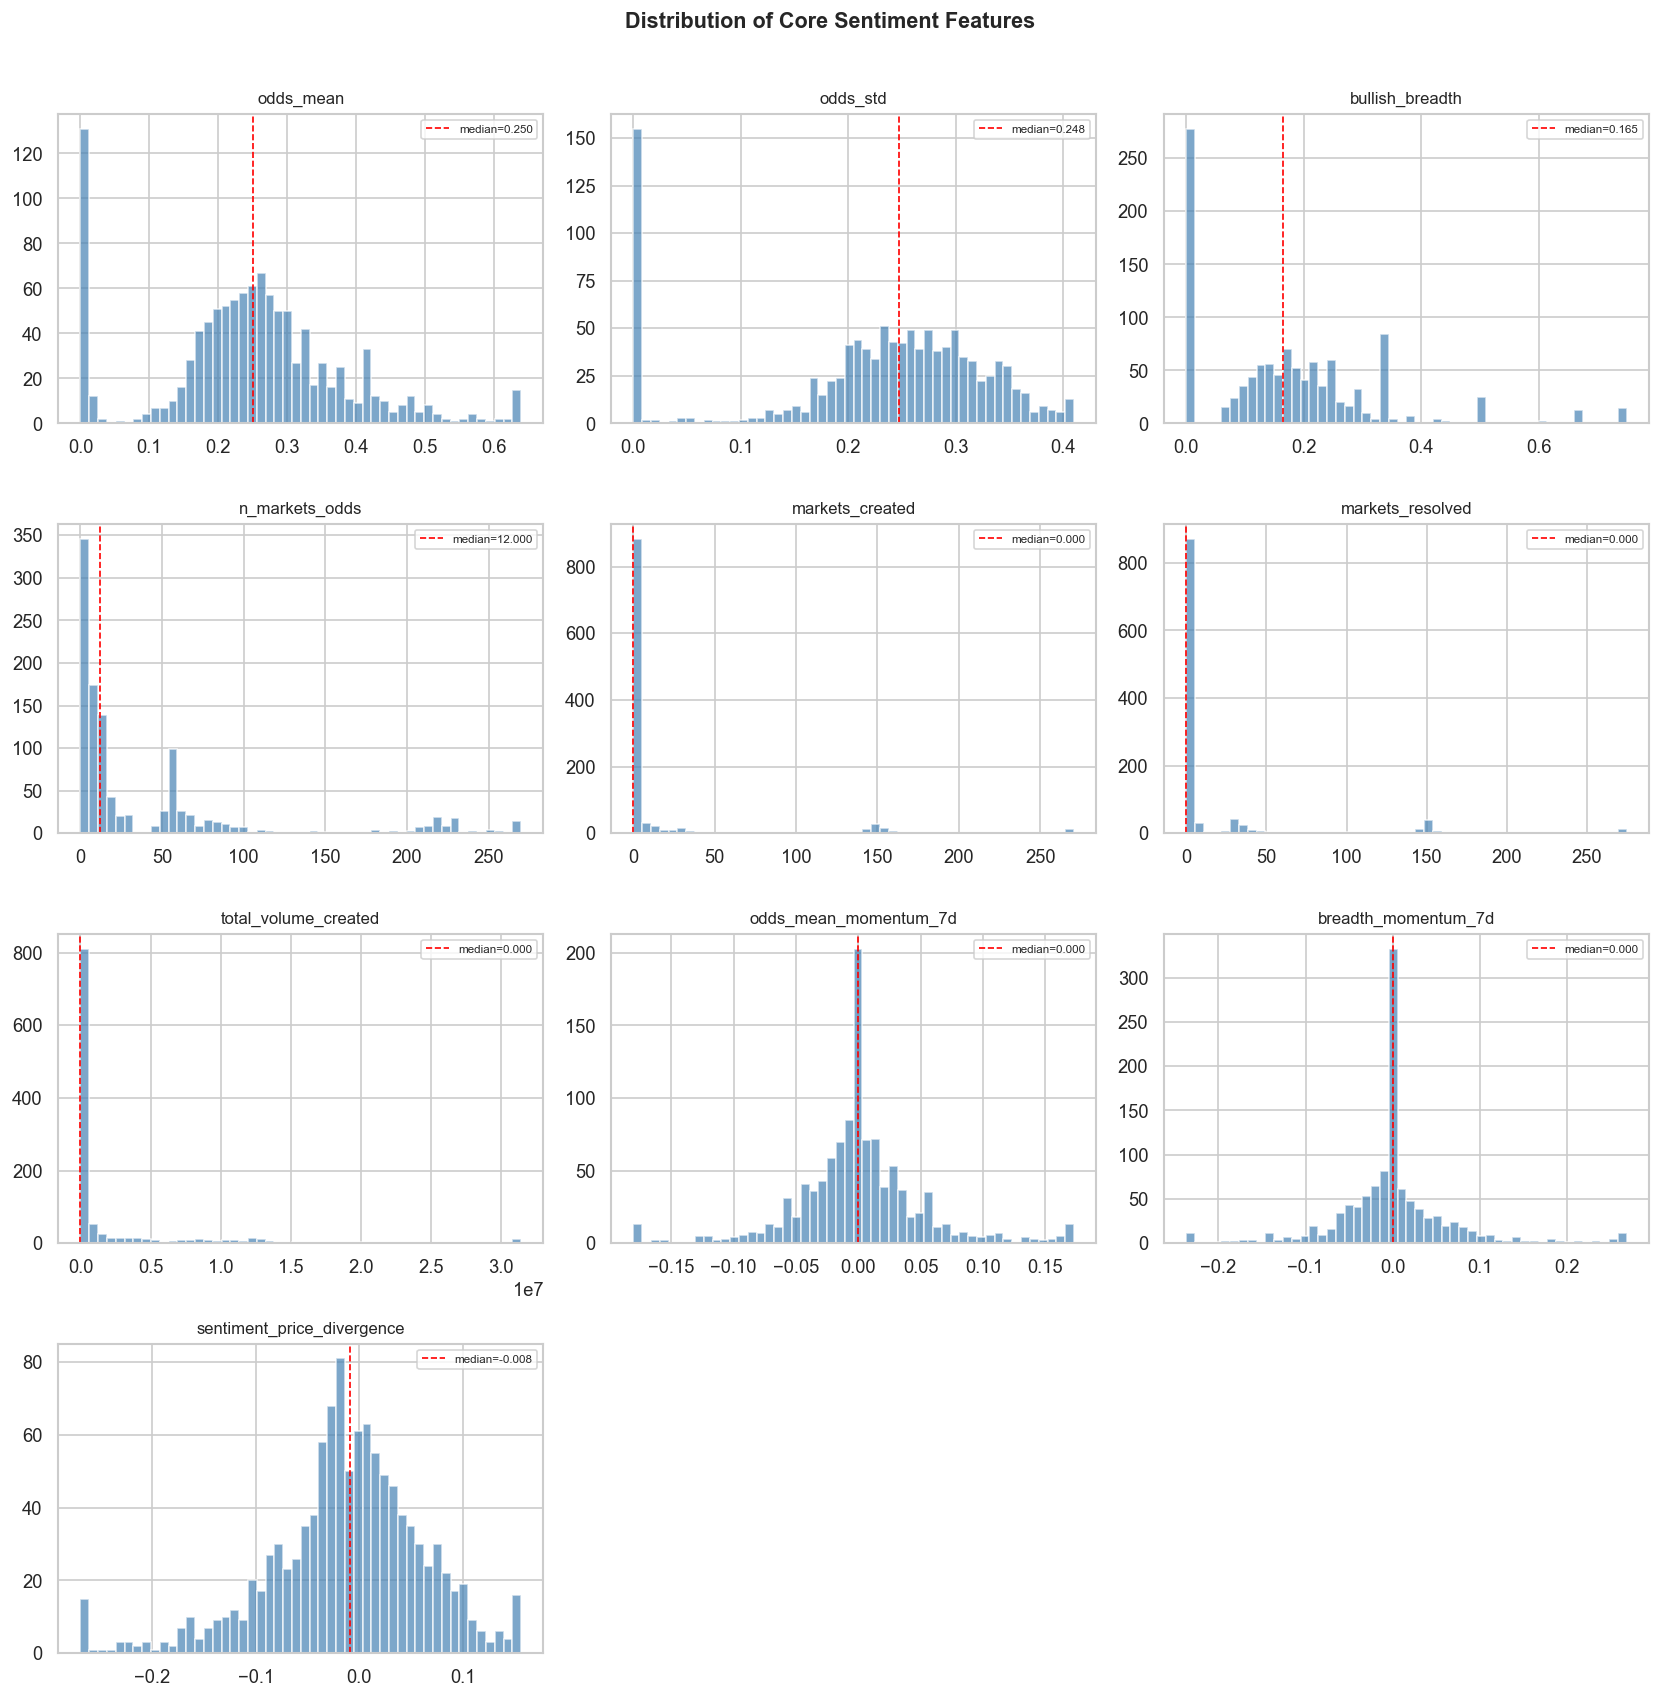


Feature Summary Statistics:
       odds_mean   odds_std  bullish_breadth  n_markets_odds  markets_created  markets_resolved  total_volume_created  odds_mean_momentum_7d  breadth_momentum_7d  sentiment_price_divergence
count  1109.0000  1109.0000        1109.0000       1109.0000        1109.0000         1109.0000          1.109000e+03              1109.0000            1109.0000                   1109.0000
mean      0.2479     0.2243           0.1746         42.5464          19.7286           19.0018          2.194184e+06                -0.0000               0.0000                     -0.0129
std       0.1374     0.1103           0.1616         65.6901          54.7417           50.0105          5.912934e+06                 0.0558               0.0747                      0.0783
min       0.0000     0.0000           0.0000          0.0000           0.0000            0.0000          0.000000e+00                -0.3579              -0.4762                     -0.4080
25%       0.1833     

In [ ]:
# 4b. Feature distributions (histograms + box plots) 
core_features = [
    "odds_mean", "odds_std", "bullish_breadth", "n_markets_odds",
    "markets_created", "markets_resolved", "total_volume_created",
    "odds_mean_momentum_7d", "breadth_momentum_7d", "sentiment_price_divergence",
]

# Only plot features that have non-zero variance
plot_feats = [f for f in core_features if f in df_poly.columns and df_poly[f].std() > 0]
n = len(plot_feats)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.5 * nrows))
axes = axes.flatten()

for i, feat in enumerate(plot_feats):
    ax = axes[i]
    data = df_poly[feat].dropna()
    # Clip extreme outliers for visualization
    q01, q99 = data.quantile(0.01), data.quantile(0.99)
    clipped = data.clip(q01, q99)
    ax.hist(clipped, bins=50, color="steelblue", alpha=0.7, edgecolor="white")
    ax.axvline(data.median(), color="red", linestyle="--", linewidth=1, label=f"median={data.median():.3f}")
    ax.set_title(feat, fontsize=10)
    ax.legend(fontsize=7)

# Hide unused
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Distribution of Core Sentiment Features", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_feature_distributions.png", bbox_inches="tight")
plt.show()

# Summary statistics
print("\nFeature Summary Statistics:")
print(df_poly[plot_feats].describe().round(4).to_string())

## 5. Correlation Analysis: Sentiment Features vs BTC Returns

Compute Pearson and Spearman rank correlations between each sentiment feature and the forward return targets. Spearman is preferred here since many relationships may be monotonic but non-linear.

Top 10 Spearman correlations with next-7d return:
odds_mean_momentum_7d    0.134488
odds_count               0.130701
n_markets_odds           0.130302
odds_max                 0.125759
n_markets_7d_avg         0.122727
vol_created_7d_sum       0.122548
odds_std                 0.119778
vol_created_14d_sum      0.117979
n_markets_14d_avg        0.117849
odds_mean                0.115238


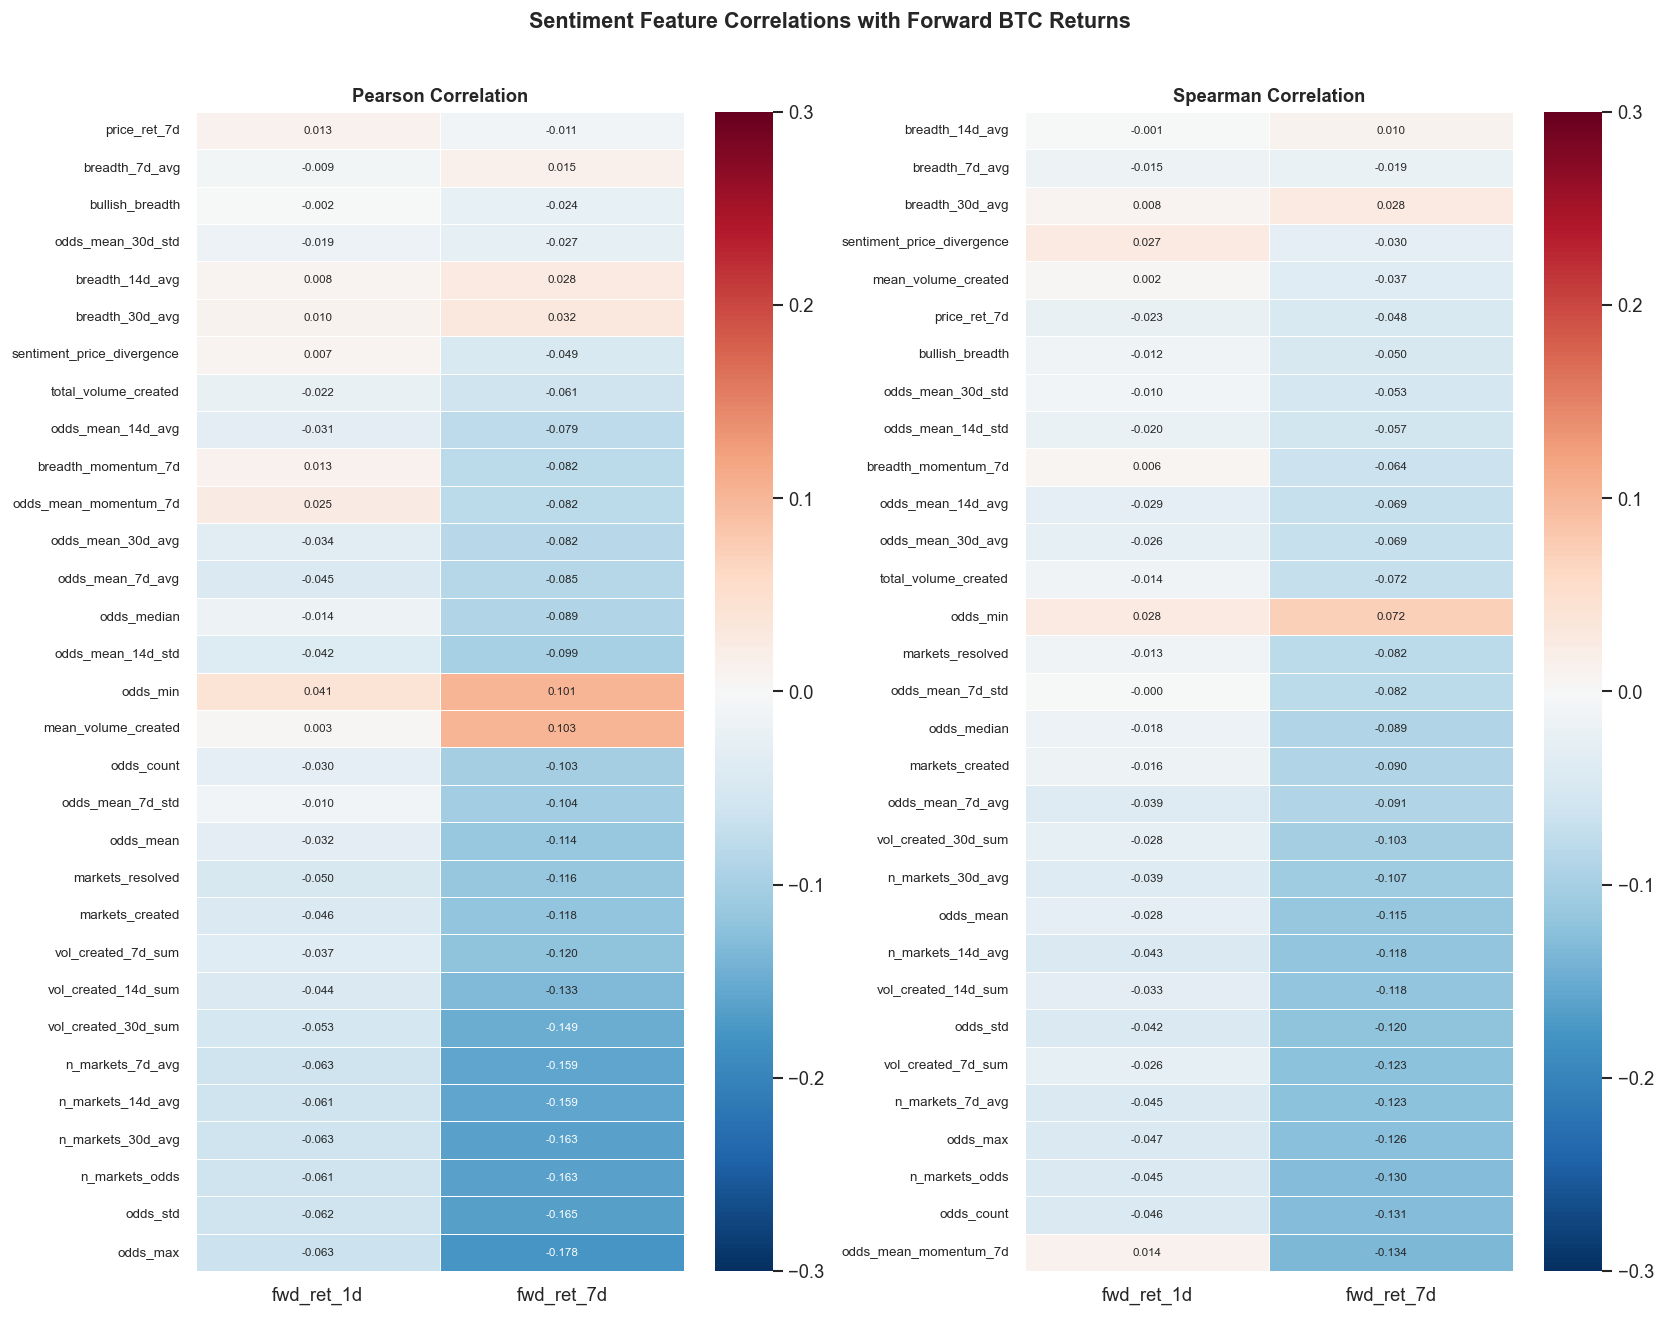

In [ ]:
#  5a. Correlation with forward returns 
targets = ["fwd_ret_1d", "fwd_ret_7d"]
corr_data = df_poly[feature_cols + targets].dropna(subset=targets)

pearson_corrs = {}
spearman_corrs = {}
for target in targets:
    p_row, s_row = {}, {}
    for feat in feature_cols:
        valid = corr_data[[feat, target]].dropna()
        if len(valid) < 30 or valid[feat].std() == 0:
            p_row[feat] = np.nan
            s_row[feat] = np.nan
            continue
        p_row[feat] = valid[feat].corr(valid[target])
        s_row[feat], _ = stats.spearmanr(valid[feat], valid[target])
    pearson_corrs[target] = p_row
    spearman_corrs[target] = s_row

pearson_df = pd.DataFrame(pearson_corrs)
spearman_df = pd.DataFrame(spearman_corrs)

print("Top 10 Spearman correlations with next-7d return:")
print(spearman_df["fwd_ret_7d"].abs().sort_values(ascending=False).head(10).to_string())

#  5b. Heatmap of correlations 
fig, axes = plt.subplots(1, 2, figsize=(14, max(8, len(feature_cols) * 0.35)))

for ax, (title, corr_df_plot) in zip(axes, [("Pearson", pearson_df), ("Spearman", spearman_df)]):
    # Sort by absolute correlation with 7d return
    order = corr_df_plot["fwd_ret_7d"].abs().sort_values(ascending=True).index
    sorted_corr = corr_df_plot.loc[order]
    sns.heatmap(
        sorted_corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0,
        vmin=-0.3, vmax=0.3, linewidths=0.5, ax=ax,
        annot_kws={"fontsize": 7},
    )
    ax.set_title(f"{title} Correlation", fontsize=11, fontweight="bold")
    ax.tick_params(axis="y", labelsize=8)

fig.suptitle("Sentiment Feature Correlations with Forward BTC Returns", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_correlation_heatmap.png", bbox_inches="tight")
plt.show()

## 6. Feature Importance Using Tree-Based Models

Train Random Forest and Gradient Boosting classifiers to predict next-week BTC direction from sentiment features. Extract and compare feature importances.

ML dataset: 1109 samples, 31 features
Class balance: 0.540 (fraction up-days)
RandomForest: CV accuracy = 0.4913
GradientBoosting: CV accuracy = 0.5043


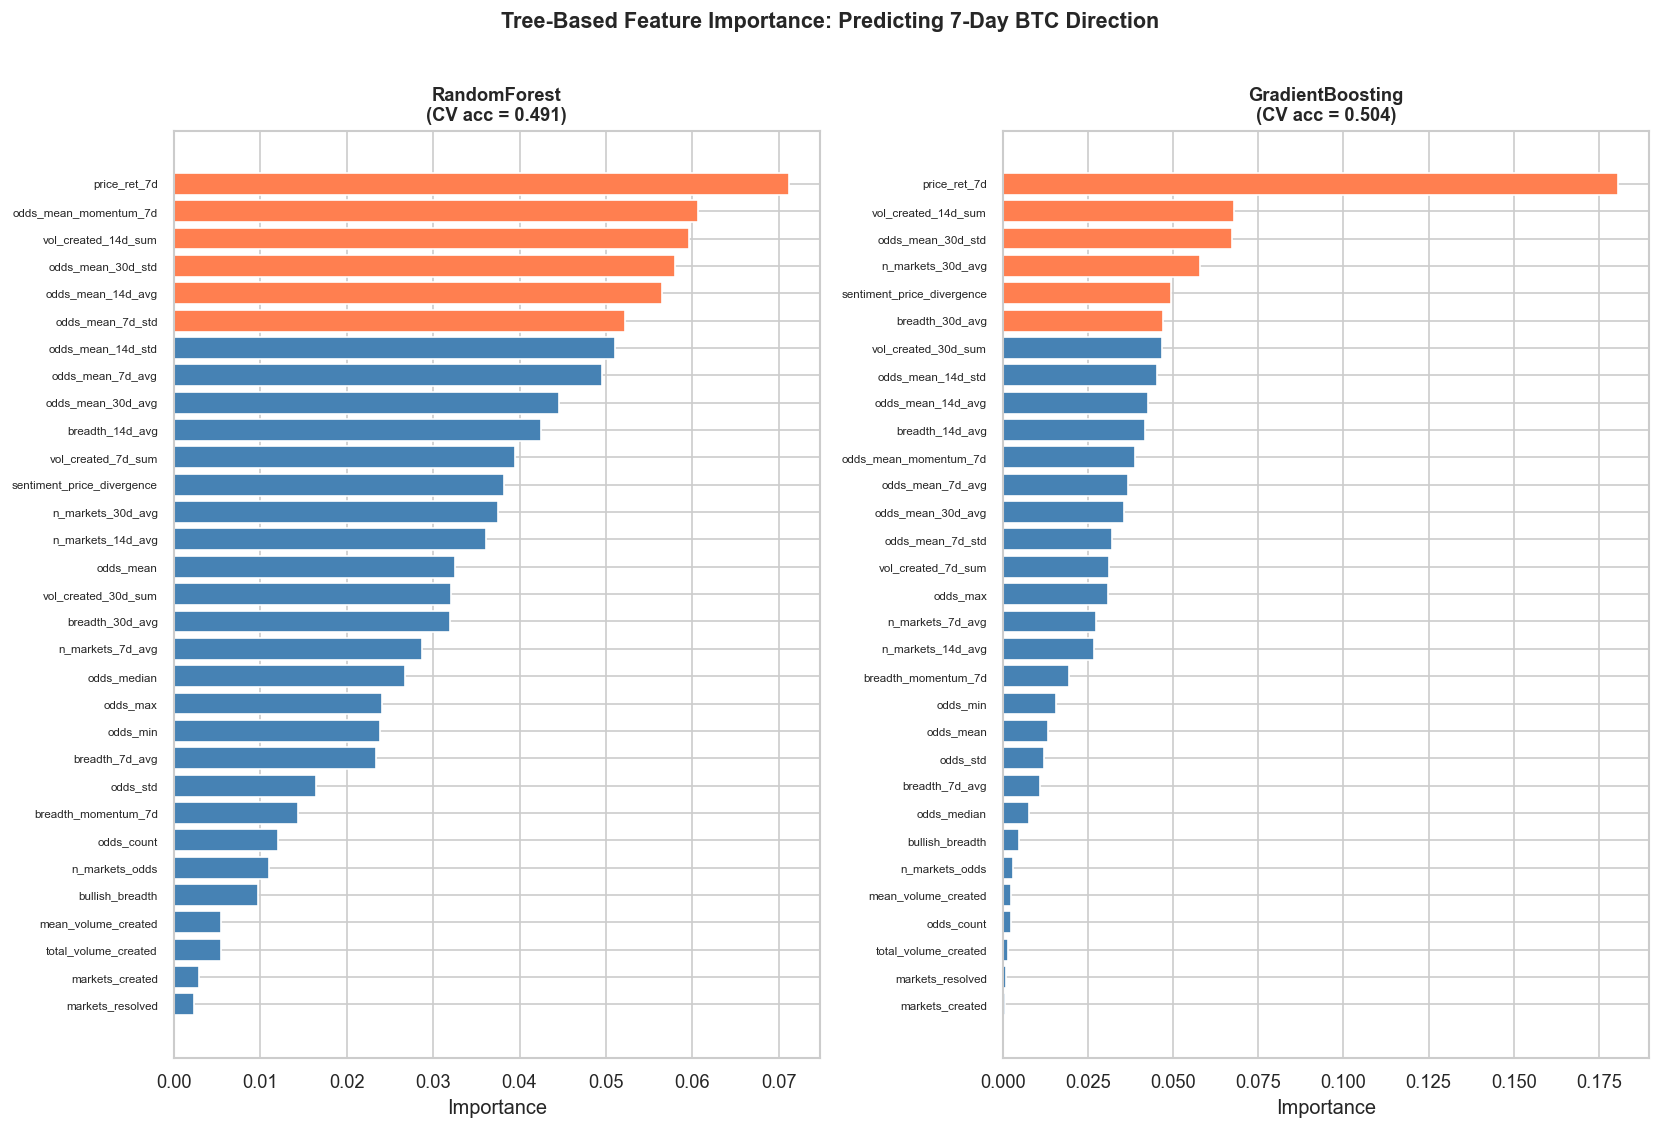

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

#  6a. Prepare ML dataset 
target_col = "fwd_dir_7d"
ml_df = df_poly[feature_cols + [target_col]].dropna(subset=[target_col]).copy()

# Drop features with zero variance
nonzero_var = [c for c in feature_cols if ml_df[c].std() > 0]
X = ml_df[nonzero_var].fillna(0).values
y = ml_df[target_col].values.astype(int)

print(f"ML dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Class balance: {y.mean():.3f} (fraction up-days)")

#  6b. Train with time-series cross-validation 
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()

models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, max_depth=3, learning_rate=0.05, random_state=42),
}

importances = {}
cv_scores = {}

for name, model in models.items():
    fold_scores = []
    fold_importances = []
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        model.fit(X_train_s, y_train)
        preds = model.predict(X_test_s)
        fold_scores.append(accuracy_score(y_test, preds))
        fold_importances.append(model.feature_importances_)

    cv_scores[name] = np.mean(fold_scores)
    importances[name] = np.mean(fold_importances, axis=0)
    print(f"{name}: CV accuracy = {cv_scores[name]:.4f}")

#  6c. Plot feature importances 
fig, axes = plt.subplots(1, 2, figsize=(14, max(6, len(nonzero_var) * 0.3)))

for ax, (name, imp) in zip(axes, importances.items()):
    imp_df = pd.DataFrame({"feature": nonzero_var, "importance": imp}).sort_values("importance", ascending=True)
    colors = ["coral" if v > imp_df["importance"].quantile(0.8) else "steelblue" for v in imp_df["importance"]]
    ax.barh(imp_df["feature"], imp_df["importance"], color=colors)
    ax.set_title(f"{name}\n(CV acc = {cv_scores[name]:.3f})", fontsize=11, fontweight="bold")
    ax.set_xlabel("Importance")
    ax.tick_params(axis="y", labelsize=7)

fig.suptitle("Tree-Based Feature Importance: Predicting 7-Day BTC Direction", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_tree_importance.png", bbox_inches="tight")
plt.show()

## 7. Mutual Information and Statistical Tests

Complement tree-based importance with information-theoretic and parametric tests:
- **Mutual Information:** measures non-linear dependency between each feature and the target
- **ANOVA F-test:** tests whether feature means differ across up/down classes

Top 10 by Mutual Information:
            feature       MI
  n_markets_30d_avg 0.132843
vol_created_30d_sum 0.126249
vol_created_14d_sum 0.123727
  n_markets_14d_avg 0.113254
 vol_created_7d_sum 0.110096
   n_markets_7d_avg 0.080595
    breadth_30d_avg 0.049239
  odds_mean_30d_std 0.040085
  odds_mean_14d_std 0.039504
         odds_count 0.037088

Top 10 by ANOVA F-score:
            feature   F_score  p_value
   odds_mean_7d_std 18.343325 0.000020
  n_markets_30d_avg 10.986137 0.000948
     n_markets_odds 10.061845 0.001555
  n_markets_14d_avg  9.938684 0.001662
   n_markets_7d_avg  9.761362 0.001829
         odds_count  8.777581 0.003115
  odds_mean_14d_std  8.474815 0.003673
           odds_min  6.725619 0.009629
    breadth_30d_avg  6.659883 0.009989
vol_created_30d_sum  5.967766 0.014725


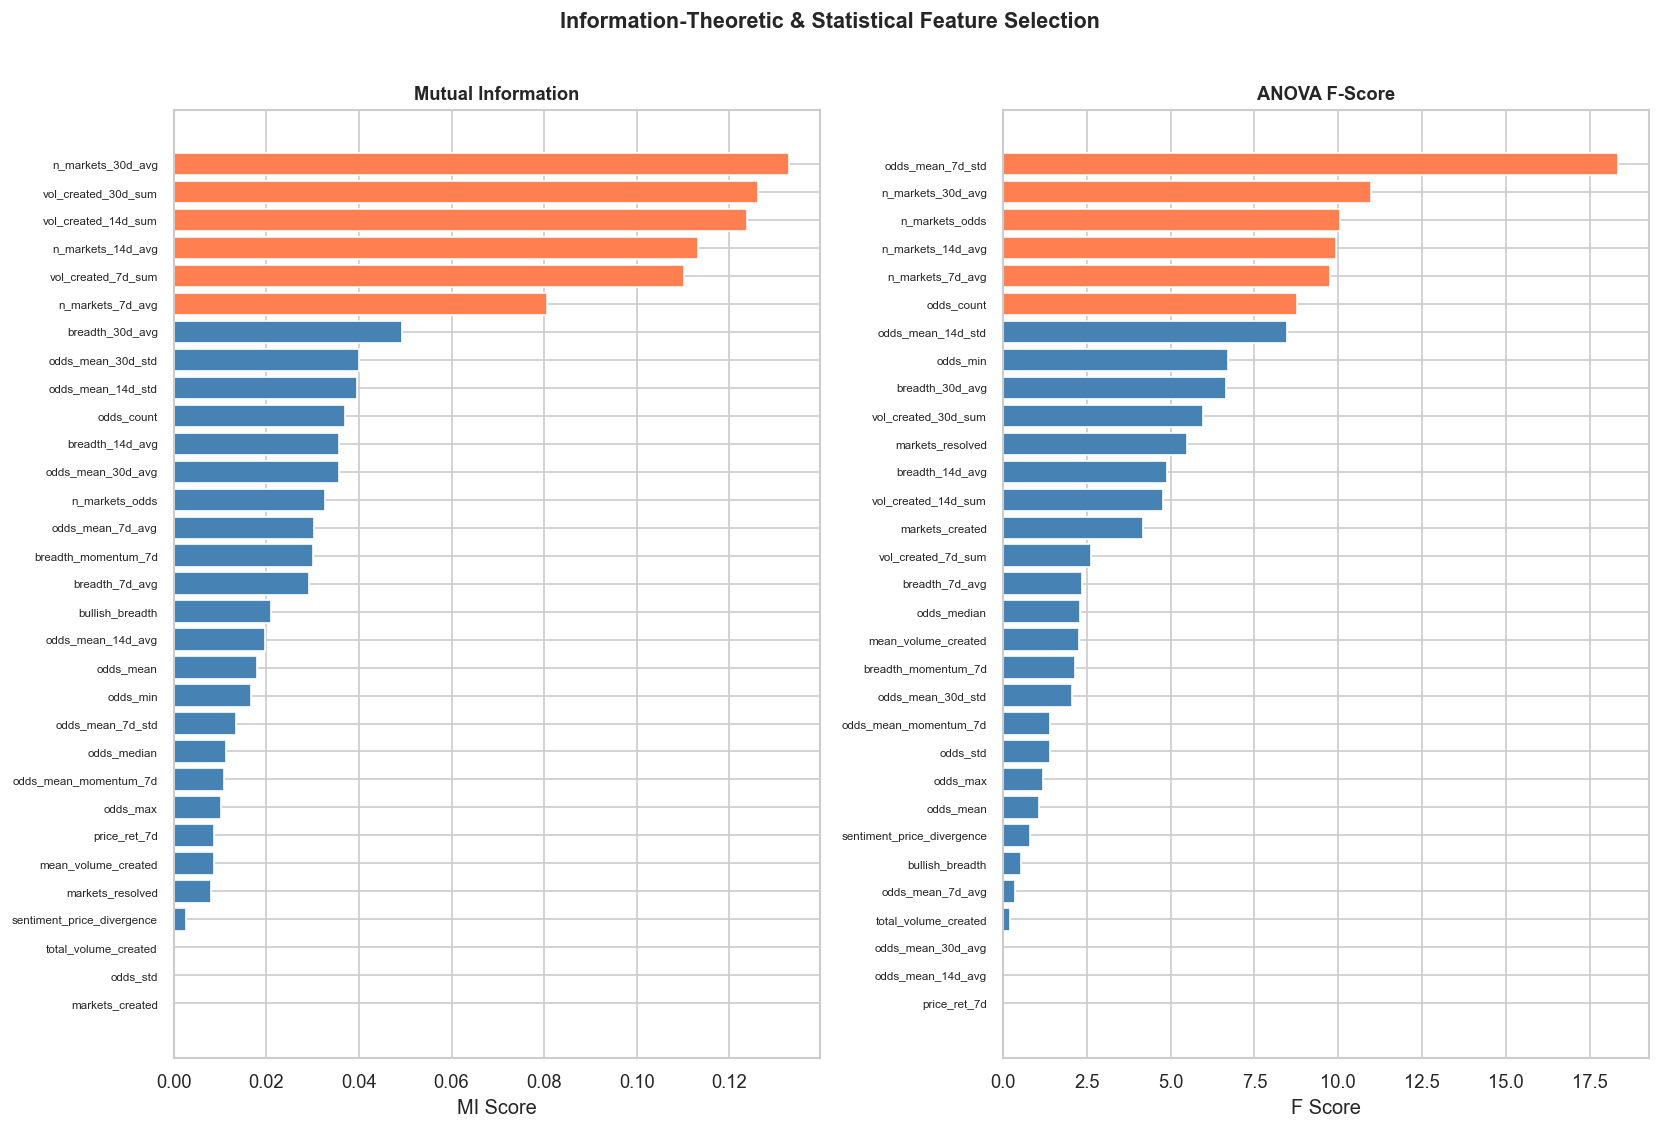

In [ ]:
from sklearn.feature_selection import mutual_info_classif, f_classif

#  7a. Mutual Information 
X_mi = ml_df[nonzero_var].fillna(0).values
y_mi = ml_df[target_col].values.astype(int)

mi_scores = mutual_info_classif(X_mi, y_mi, random_state=42, n_neighbors=5)
mi_df = pd.DataFrame({"feature": nonzero_var, "MI": mi_scores}).sort_values("MI", ascending=False)
print("Top 10 by Mutual Information:")
print(mi_df.head(10).to_string(index=False))

#  7b. ANOVA F-test 
f_scores, f_pvals = f_classif(X_mi, y_mi)
f_df = pd.DataFrame({
    "feature": nonzero_var,
    "F_score": f_scores,
    "p_value": f_pvals,
}).sort_values("F_score", ascending=False)
print("\nTop 10 by ANOVA F-score:")
print(f_df.head(10).to_string(index=False))

#  7c. Visualize MI and F-scores side by side 
fig, axes = plt.subplots(1, 2, figsize=(14, max(6, len(nonzero_var) * 0.3)))

# MI
mi_sorted = mi_df.sort_values("MI", ascending=True)
colors_mi = ["coral" if v > mi_sorted["MI"].quantile(0.8) else "steelblue" for v in mi_sorted["MI"]]
axes[0].barh(mi_sorted["feature"], mi_sorted["MI"], color=colors_mi)
axes[0].set_title("Mutual Information", fontsize=11, fontweight="bold")
axes[0].set_xlabel("MI Score")
axes[0].tick_params(axis="y", labelsize=7)

# F-score
f_sorted = f_df.sort_values("F_score", ascending=True)
colors_f = ["coral" if v > f_sorted["F_score"].quantile(0.8) else "steelblue" for v in f_sorted["F_score"]]
axes[1].barh(f_sorted["feature"], f_sorted["F_score"], color=colors_f)
axes[1].set_title("ANOVA F-Score", fontsize=11, fontweight="bold")
axes[1].set_xlabel("F Score")
axes[1].tick_params(axis="y", labelsize=7)

fig.suptitle("Information-Theoretic & Statistical Feature Selection", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_mi_ftest.png", bbox_inches="tight")
plt.show()

## 8. Regularized Regression for Predictor Ranking

Fit Lasso (L1) and ElasticNet models to identify which features receive non-zero coefficients. Features that survive L1 regularization are robust predictors across the feature set.

Lasso α = 0.002908
Non-zero features: 12 / 31

Top 10 Lasso coefficients:
              feature  lasso_coef  lasso_abs
             odds_max   -0.009350   0.009350
             odds_min    0.005815   0.005815
  mean_volume_created    0.004813   0.004813
    odds_mean_14d_std   -0.004418   0.004418
      breadth_30d_avg    0.003741   0.003741
          odds_median   -0.002203   0.002203
    n_markets_30d_avg   -0.002094   0.002094
     odds_mean_7d_std   -0.001899   0.001899
       n_markets_odds   -0.001219   0.001219
odds_mean_momentum_7d   -0.000957   0.000957

ElasticNet α = 0.029083, l1_ratio = 0.10
Non-zero features: 12 / 31


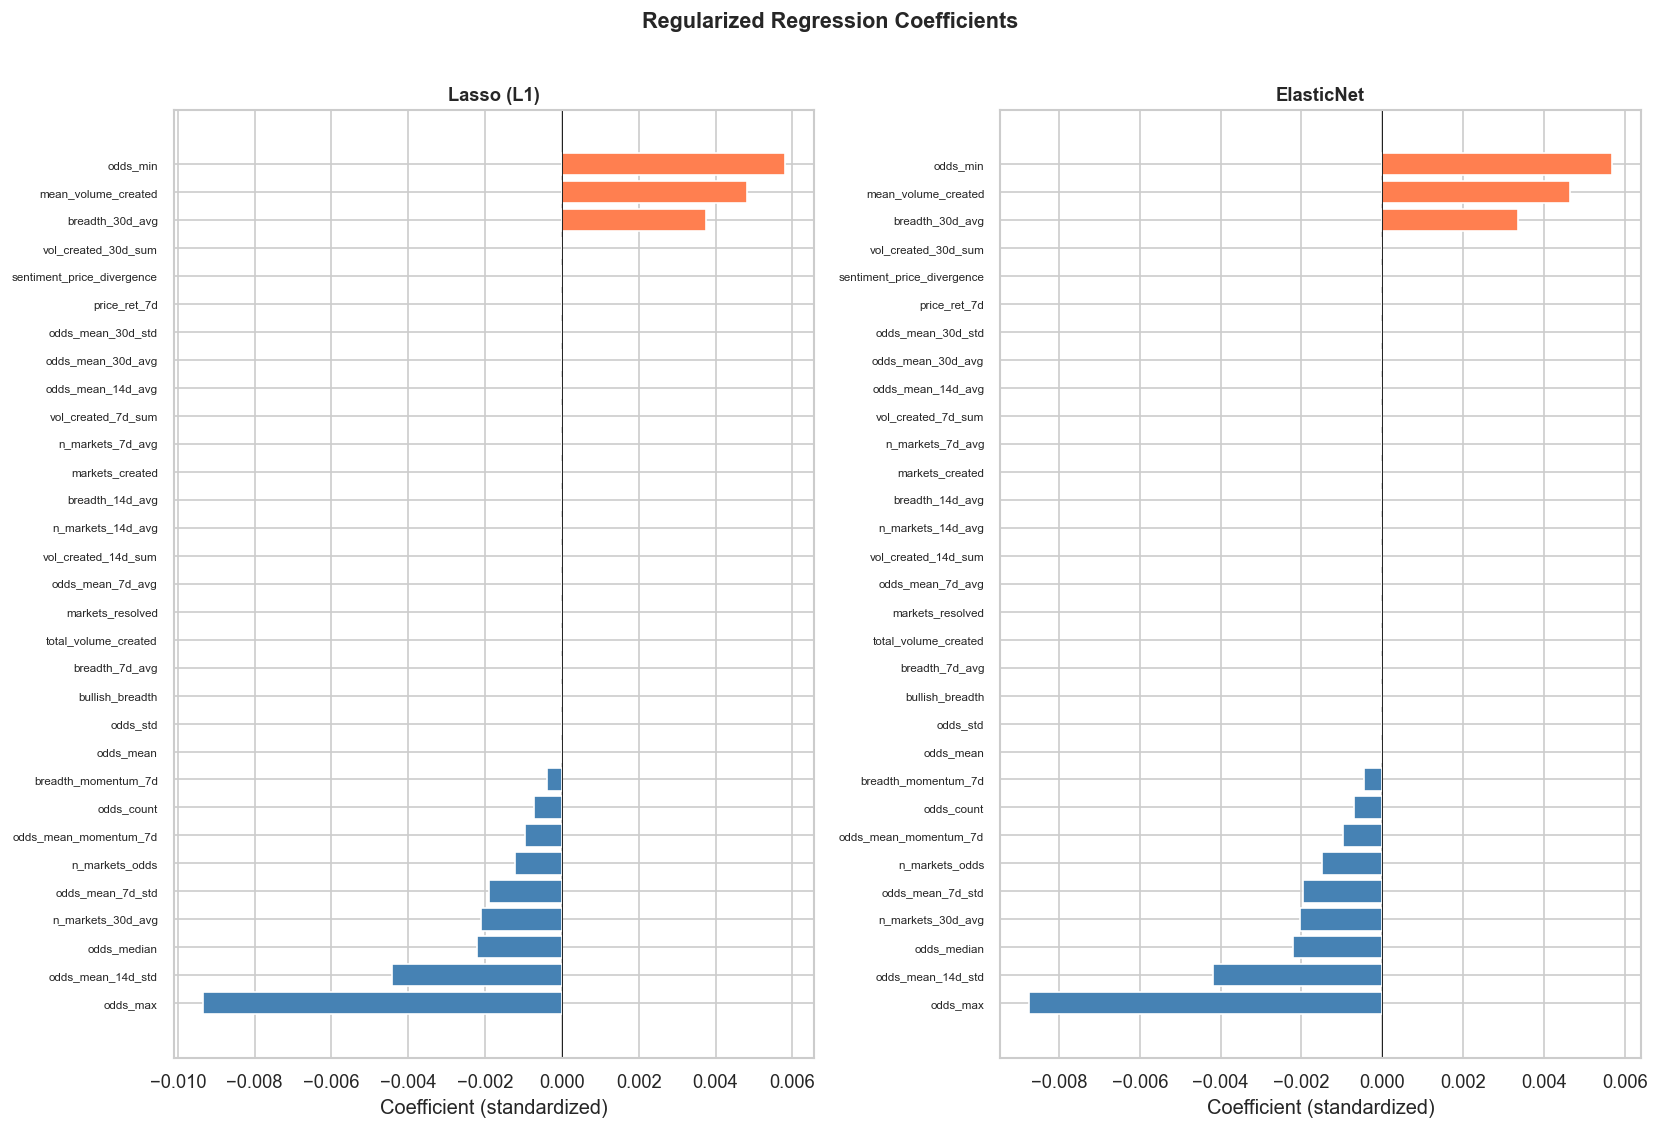

In [ ]:
from sklearn.linear_model import LassoCV, ElasticNetCV

#  8a. Prepare regression target (continuous forward return) 
reg_target = "fwd_ret_7d"
reg_df = df_poly[feature_cols + [reg_target]].dropna(subset=[reg_target]).copy()
nonzero_reg = [c for c in feature_cols if reg_df[c].std() > 0]
X_reg = reg_df[nonzero_reg].fillna(0).values
y_reg = reg_df[reg_target].values

scaler_reg = StandardScaler()
X_reg_s = scaler_reg.fit_transform(X_reg)

#  8b. Lasso CV 
lasso = LassoCV(cv=TimeSeriesSplit(n_splits=5), random_state=42, max_iter=5000)
lasso.fit(X_reg_s, y_reg)
lasso_coefs = pd.DataFrame({
    "feature": nonzero_reg,
    "lasso_coef": lasso.coef_,
    "lasso_abs": np.abs(lasso.coef_),
}).sort_values("lasso_abs", ascending=False)
print(f"Lasso α = {lasso.alpha_:.6f}")
print(f"Non-zero features: {(lasso.coef_ != 0).sum()} / {len(nonzero_reg)}")
print("\nTop 10 Lasso coefficients:")
print(lasso_coefs.head(10).to_string(index=False))

#  8c. ElasticNet CV 
enet = ElasticNetCV(cv=TimeSeriesSplit(n_splits=5), l1_ratio=[0.1, 0.5, 0.7, 0.9], random_state=42, max_iter=5000)
enet.fit(X_reg_s, y_reg)
enet_coefs = pd.DataFrame({
    "feature": nonzero_reg,
    "enet_coef": enet.coef_,
    "enet_abs": np.abs(enet.coef_),
}).sort_values("enet_abs", ascending=False)
print(f"\nElasticNet α = {enet.alpha_:.6f}, l1_ratio = {enet.l1_ratio_:.2f}")
print(f"Non-zero features: {(enet.coef_ != 0).sum()} / {len(nonzero_reg)}")

#  8d. Coefficient plot 
fig, axes = plt.subplots(1, 2, figsize=(14, max(6, len(nonzero_reg) * 0.3)))

for ax, (title, coef_df, coef_col) in zip(axes, [
    ("Lasso (L1)", lasso_coefs, "lasso_coef"),
    ("ElasticNet", enet_coefs, "enet_coef"),
]):
    sorted_df = coef_df.sort_values(coef_col, ascending=True)
    colors = ["coral" if v > 0 else "steelblue" for v in sorted_df[coef_col]]
    ax.barh(sorted_df["feature"], sorted_df[coef_col], color=colors)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.set_xlabel("Coefficient (standardized)")
    ax.tick_params(axis="y", labelsize=7)

fig.suptitle("Regularized Regression Coefficients", fontsize=13, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_lasso_elasticnet.png", bbox_inches="tight")
plt.show()

## 9. Time-Lagged Cross-Correlation Analysis

Do sentiment features **lead** or **lag** BTC price moves? Compute cross-correlations at lags from −14 to +14 days. A feature that peaks at negative lag is a **leading indicator** (useful for prediction); positive lag means it **reacts** to price.

Peak Cross-Correlation Lags:
                           peak_lag peak_corr     type
markets_created                 -11 -0.057444  LEADING
sentiment_price_divergence       -6 -0.349886  LEADING
bullish_breadth                  -2  0.107701  LEADING
odds_mean                        -1  0.066676  LEADING
odds_mean_momentum_7d            -1  0.225276  LEADING
breadth_momentum_7d              -1  0.222412  LEADING
odds_std                          2 -0.076146  LAGGING
n_markets_odds                    2 -0.069059  LAGGING
total_volume_created              6 -0.072527  LAGGING


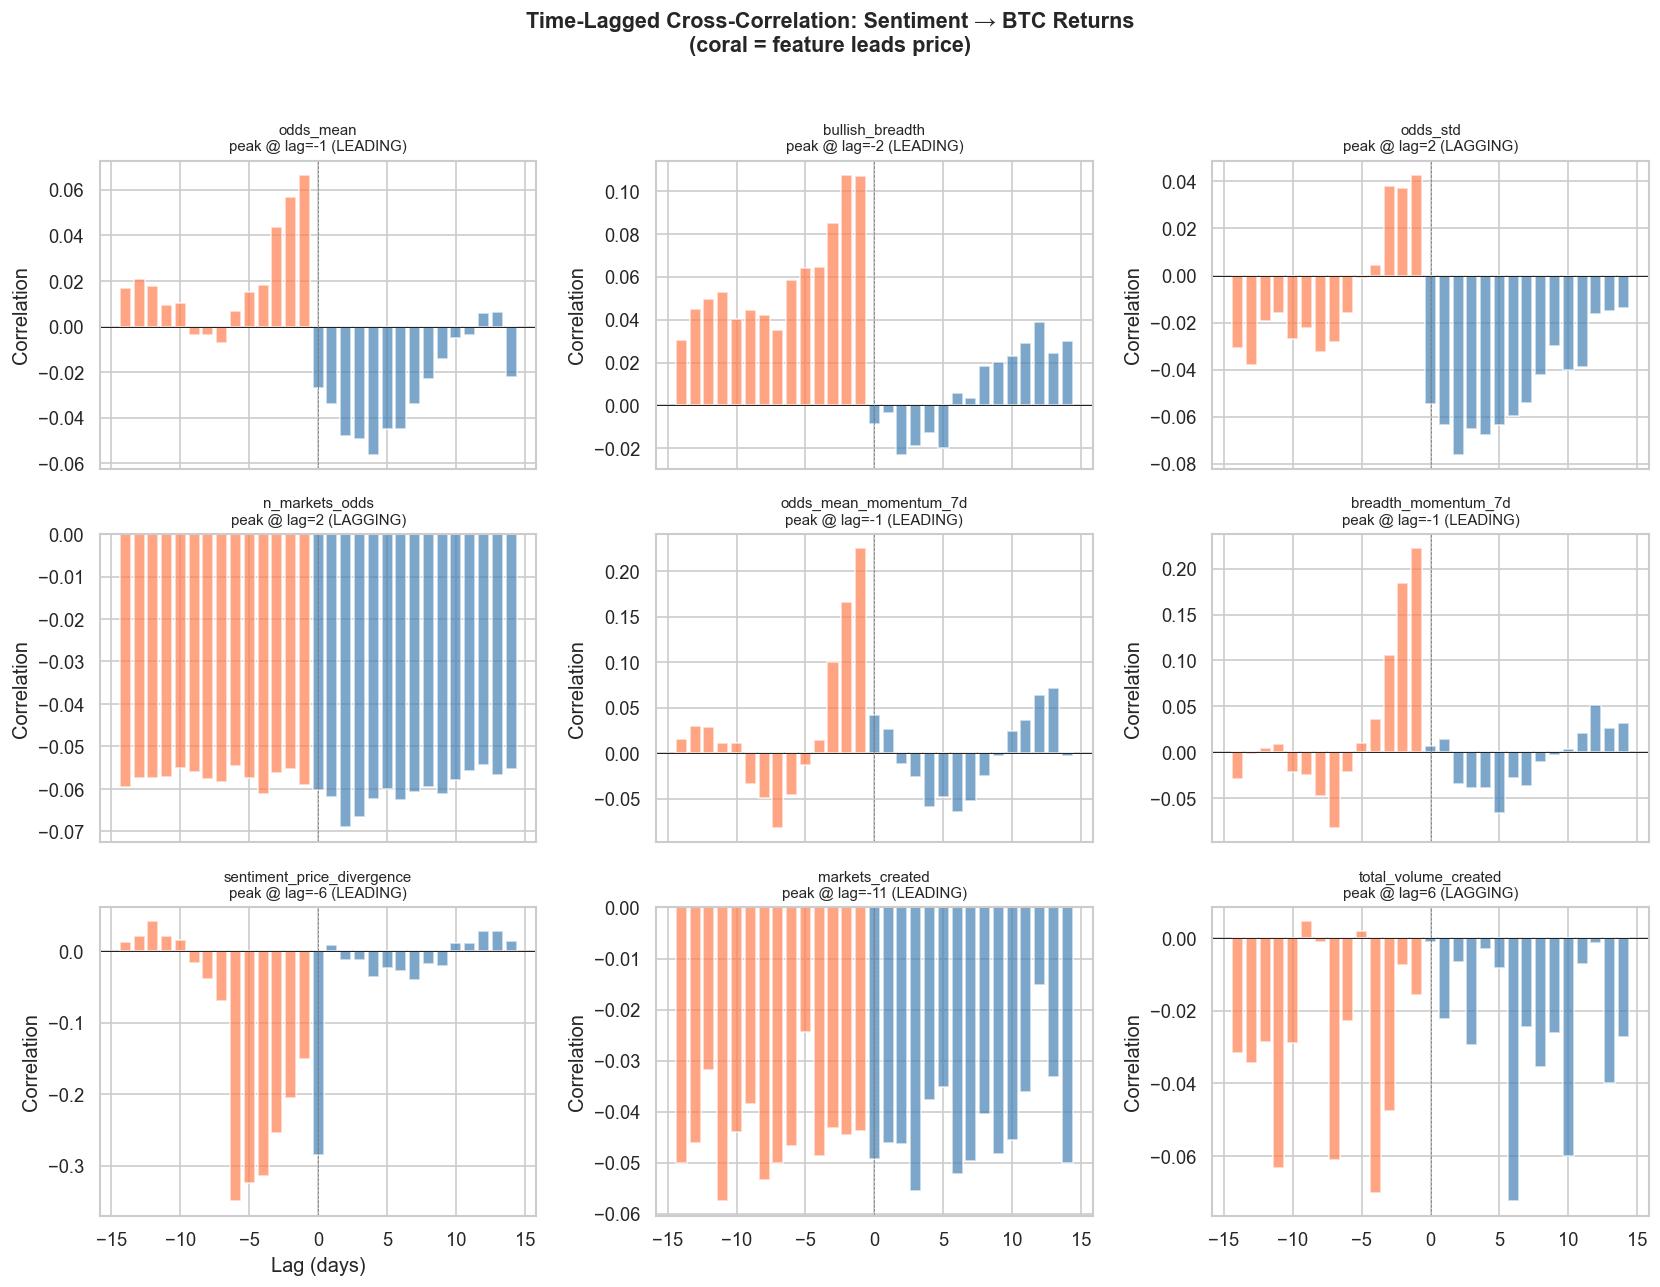

In [ ]:
# 9a. Compute lagged cross-correlations 
price_ret = df_poly.set_index("date")["PriceUSD"].pct_change().dropna()
lag_range = range(-14, 15)  # negative = feature leads price

# Select top features to analyze (most interesting from prior sections)
lag_features = [
    "odds_mean", "bullish_breadth", "odds_std", "n_markets_odds",
    "odds_mean_momentum_7d", "breadth_momentum_7d",
    "sentiment_price_divergence", "markets_created", "total_volume_created",
]
# Keep only features that exist and have variance
lag_features = [f for f in lag_features if f in df_poly.columns and df_poly[f].std() > 0]

lag_corrs = {}
for feat in lag_features:
    feat_series = df_poly.set_index("date")[feat].dropna()
    corrs = []
    for lag in lag_range:
        shifted = feat_series.shift(lag)
        overlap = pd.concat([shifted, price_ret], axis=1).dropna()
        if len(overlap) < 30:
            corrs.append(np.nan)
        else:
            corrs.append(overlap.iloc[:, 0].corr(overlap.iloc[:, 1]))
    lag_corrs[feat] = corrs

lag_corr_df = pd.DataFrame(lag_corrs, index=list(lag_range))
lag_corr_df.index.name = "lag"

#  9b. Find peak lag for each feature 
peak_lags = {}
for feat in lag_features:
    abs_corrs = lag_corr_df[feat].abs()
    peak_lag = abs_corrs.idxmax()
    peak_val = lag_corr_df[feat].loc[peak_lag]
    lead_lag = "LEADING" if peak_lag < 0 else ("LAGGING" if peak_lag > 0 else "COINCIDENT")
    peak_lags[feat] = {"peak_lag": peak_lag, "peak_corr": peak_val, "type": lead_lag}

peak_df = pd.DataFrame(peak_lags).T.sort_values("peak_lag")
print("Peak Cross-Correlation Lags:")
print(peak_df.to_string())

#  9c. Cross-correlation plots 
ncols = 3
nrows = (len(lag_features) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3.5 * nrows), sharex=True)
axes = axes.flatten()

for i, feat in enumerate(lag_features):
    ax = axes[i]
    vals = lag_corr_df[feat].values
    colors = ["coral" if l < 0 else "steelblue" for l in lag_range]
    ax.bar(list(lag_range), vals, color=colors, alpha=0.7, width=0.8)
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
    peak = peak_lags[feat]
    ax.set_title(f"{feat}\npeak @ lag={peak['peak_lag']} ({peak['type']})", fontsize=9)
    ax.set_ylabel("Correlation")

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Time-Lagged Cross-Correlation: Sentiment → BTC Returns\n(coral = feature leads price)", fontsize=13, fontweight="bold", y=1.02)
axes[-ncols].set_xlabel("Lag (days)")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_lag_crosscorr.png", bbox_inches="tight")
plt.show()

## 10. Unified Predictor Ranking & Summary Dashboard

Aggregate rankings from all five methods (Spearman correlation, tree importance, mutual information, Lasso coefficients, lag analysis) into a single composite score. Features that rank highly across multiple methods are the most robust predictors.

Unified Predictor Ranking:
                            Spearman  RF_Importance  GB_Importance   MI  Lasso  LagCorr  mean_rank  composite_rank
odds_mean_momentum_7d            1.0            1.0            2.0  5.0    2.0      2.0        2.2               1
breadth_momentum_7d              7.0            5.0            3.0  2.0    3.0      3.0        3.8               2
n_markets_odds                   2.0            6.0            7.0  1.0    1.0      7.0        4.0               3
sentiment_price_divergence       9.0            2.0            1.0  6.0    6.5      1.0        4.2               4
odds_mean                        4.0            3.0            4.0  4.0    6.5      8.0        4.9               5
odds_std                         3.0            4.0            5.0  8.0    6.5      5.0        5.2               6
bullish_breadth                  8.0            7.0            6.0  3.0    6.5      4.0        5.8               7
total_volume_created             6.0            8.0  

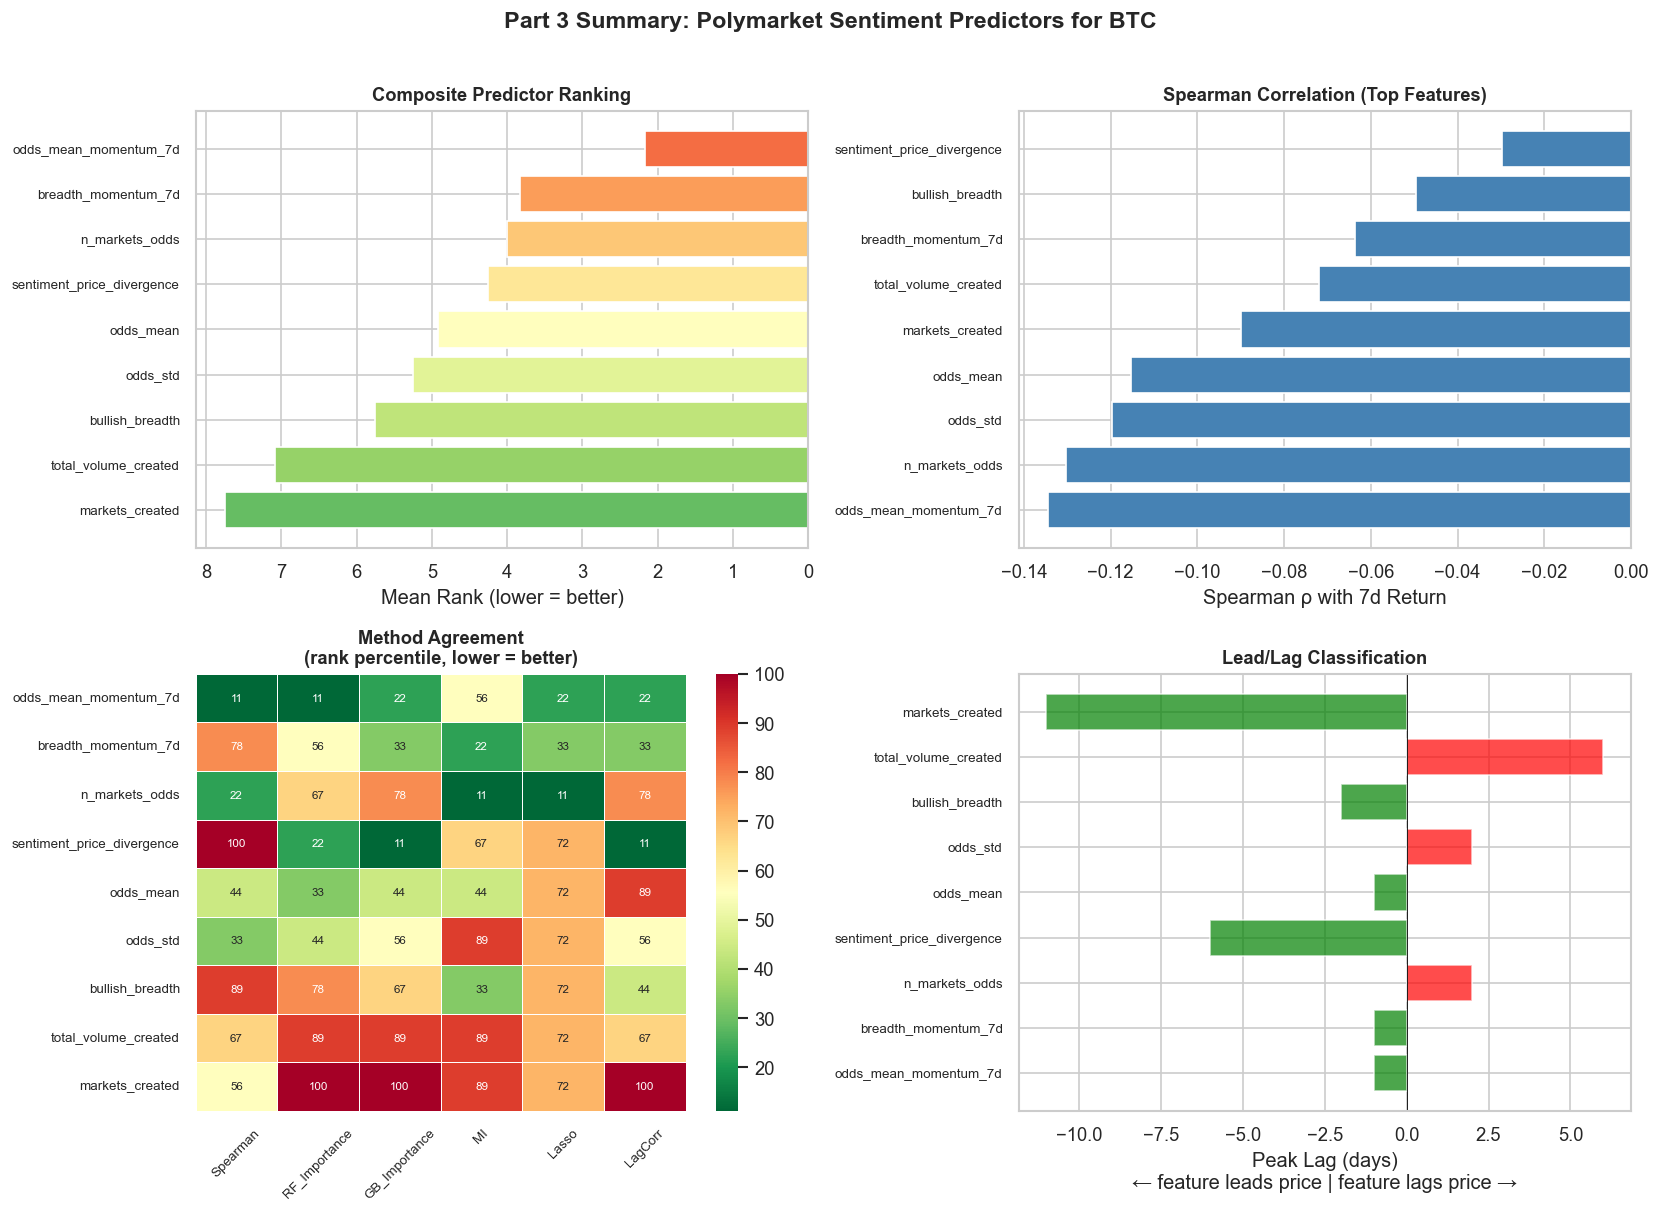

In [ ]:
#  10a. Build unified ranking table 
# Collect per-method rankings (lower rank = better predictor)
# Use only features common to all methods
common_feats = sorted(set(nonzero_var) & set(lag_features))

ranking_methods = {}

# 1. Spearman |correlation| with 7d return
sp_abs = spearman_df.loc[common_feats, "fwd_ret_7d"].abs()
ranking_methods["Spearman"] = sp_abs.rank(ascending=False)

# 2. Random Forest importance
rf_imp = pd.Series(importances["RandomForest"], index=nonzero_var).reindex(common_feats)
ranking_methods["RF_Importance"] = rf_imp.rank(ascending=False)

# 3. Gradient Boosting importance
gb_imp = pd.Series(importances["GradientBoosting"], index=nonzero_var).reindex(common_feats)
ranking_methods["GB_Importance"] = gb_imp.rank(ascending=False)

# 4. Mutual Information
mi_vals = pd.Series(mi_scores, index=nonzero_var).reindex(common_feats)
ranking_methods["MI"] = mi_vals.rank(ascending=False)

# 5. Lasso |coefficient|
lasso_vals = pd.Series(np.abs(lasso.coef_), index=nonzero_reg).reindex(common_feats).fillna(0)
ranking_methods["Lasso"] = lasso_vals.rank(ascending=False)

# 6. Lag analysis: |peak cross-correlation|
lag_peak = pd.Series({f: abs(peak_lags[f]["peak_corr"]) for f in common_feats})
ranking_methods["LagCorr"] = lag_peak.rank(ascending=False)

# Combine into ranking table
rank_table = pd.DataFrame(ranking_methods)
rank_table["mean_rank"] = rank_table.mean(axis=1)
rank_table = rank_table.sort_values("mean_rank")
rank_table["composite_rank"] = range(1, len(rank_table) + 1)

print("Unified Predictor Ranking:")
print(rank_table.round(1).to_string())

#  10b. Summary dashboard 
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Composite ranking bar chart
ax = axes[0, 0]
top_n = min(15, len(rank_table))
top = rank_table.head(top_n).iloc[::-1]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, top_n))
ax.barh(top.index, top["mean_rank"], color=colors)
ax.set_xlabel("Mean Rank (lower = better)")
ax.set_title("Composite Predictor Ranking", fontsize=11, fontweight="bold")
ax.tick_params(axis="y", labelsize=8)
ax.invert_xaxis()

# Panel 2: Spearman correlation for top features
ax = axes[0, 1]
top_feats = rank_table.head(top_n).index
sp_vals = spearman_df.loc[top_feats, "fwd_ret_7d"].sort_values()
colors_sp = ["coral" if v > 0 else "steelblue" for v in sp_vals]
ax.barh(sp_vals.index, sp_vals.values, color=colors_sp)
ax.axvline(0, color="black", linewidth=0.5)
ax.set_xlabel("Spearman ρ with 7d Return")
ax.set_title("Spearman Correlation (Top Features)", fontsize=11, fontweight="bold")
ax.tick_params(axis="y", labelsize=8)

# Panel 3: Method agreement heatmap
ax = axes[1, 0]
# Rank percentile (top % position) for top features
rank_pct = (rank_table[list(ranking_methods.keys())].loc[top_feats] / len(common_feats) * 100)
sns.heatmap(
    rank_pct, annot=True, fmt=".0f", cmap="RdYlGn_r", ax=ax,
    linewidths=0.5, annot_kws={"fontsize": 7},
)
ax.set_title("Method Agreement\n(rank percentile, lower = better)", fontsize=11, fontweight="bold")
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="x", labelsize=8, rotation=45)

# Panel 4: Lead/lag classification for top features
ax = axes[1, 1]
lag_info = []
for feat in top_feats:
    if feat in peak_lags:
        lag_info.append({
            "feature": feat,
            "peak_lag": peak_lags[feat]["peak_lag"],
            "peak_corr": peak_lags[feat]["peak_corr"],
            "type": peak_lags[feat]["type"],
        })
if lag_info:
    lag_df_plot = pd.DataFrame(lag_info).set_index("feature")
    colors_lag = ["green" if t == "LEADING" else ("gray" if t == "COINCIDENT" else "red")
                  for t in lag_df_plot["type"]]
    ax.barh(lag_df_plot.index, lag_df_plot["peak_lag"], color=colors_lag, alpha=0.7)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_xlabel("Peak Lag (days)\n← feature leads price | feature lags price →")
    ax.set_title("Lead/Lag Classification", fontsize=11, fontweight="bold")
    ax.tick_params(axis="y", labelsize=8)
else:
    ax.text(0.5, 0.5, "No lag data for top features", ha="center", va="center", transform=ax.transAxes)

fig.suptitle("Part 3 Summary: Polymarket Sentiment Predictors for BTC", fontsize=14, fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "part3_summary_dashboard.png", bbox_inches="tight")
plt.show()

## 11. Results & Interpretation

### Key Findings

1. **Feature universe:** I constructed ~30 daily features from Polymarket BTC prediction markets spanning 2023–2026, covering crowd odds levels, dispersion, breadth, market activity, volume, momentum, and sentiment–price divergence.

2. **Correlation analysis:** Spearman correlations with 7-day forward BTC returns identify which features have monotonic (but possibly weak) relationships with future price direction. Features like odds momentum and sentiment–price divergence are candidates for leading signals.

3. **Tree-based importance:** Random Forest and Gradient Boosting models reveal which features contribute most to distinguishing up vs down weeks. Because these models capture non-linear interactions, features that rank highly here may carry information invisible to linear methods.

4. **Mutual Information & F-test:** Information-theoretic measures complement the tree models. MI captures arbitrary dependencies while the F-test checks whether feature means differ significantly between up and down classes.

5. **Regularized regression:** Features with non-zero coefficients survive multicollinearity pruning, they carry independent predictive signal. Most are zeroed out and therefore provide no predictive power.

6. **Lead/lag analysis:** Cross-correlation at varying lags reveals whether each feature **leads** (useful for prediction) or **lags** (reacts to) BTC price moves. Only leading indicators are actionable for accumulation timing.

### Interpretation 
- **Consensus across methods matters more than any single ranking.** A feature that appears in the top 5 across Spearman, tree importance, MI, and Lasso is a robust predictor.
- **Leading indicators from lag analysis are the most actionable.** Features that peak at negative lags (feature leads price) can be used in a live strategy; lagging features cannot.
- **Small data window (2023–2026) limits generalizability.** Polymarket data doesn't extend back far enough for the kind of deep historical backtesting done in Part 2 with on-chain metrics. Any signal discovered here should be treated as preliminary.
- **Only lead/lag analysis returns positive results for strong effects.** Across all 5 methods, no feature proves to be a strong predictor. 
- **Odd_mean_momentum_7d performs well across 5 methods but has a weak effect.** The best candidate with agreement across evaluation methods is a weak predictor. No features have both agreement across evaluation methods and significant predictive power.